### NC processor 
1. concatenates a list of netcdf along time dimension

In [1]:
import rioxarray
import rasterio as rio
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from pathlib import Path
from utils import *

In [3]:
vi = 'ndvi'
run = 'f6'
outf = f'/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/raster/{run}'
folder = '/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/nc/f5/'

# outf = f'/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/raster/{run}/'
# folder = '/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/f5/'


Path(outf).mkdir( parents = True, exist_ok = True)

ff = sorted(glob(folder+f'{vi}*.nc'))
print(len(ff),'\n',ff[0],'\n',ff[-1])

5 
 /home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/nc/f5/ndvi_2019-06-21-2020-06-07_21.nc 
 /home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/nc/f5/ndvi_2023-06-24-2024-05-25_38.nc


In [4]:
i = 0
ffpart = ff
ffpart = ff[i:]
ffpart[0], ffpart[-1]

('/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/nc/f5/ndvi_2019-06-21-2020-06-07_21.nc',
 '/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/nc/f5/ndvi_2023-06-24-2024-05-25_38.nc')

### concat 1 by 1

In [5]:
df = xr.open_dataset(ffpart[0])
df = df.rename({"longitude": "x", "latitude": "y"})
for f in ffpart[1:]:
    f_ = f.split('/')[-1]
    print(f_)
    df1 = xr.open_dataset(f)
    print(f'reprojecting {f_}')
    df1 = df1.rio.reproject_match(df)
    df = xr.concat([df,df1], dim = 'time',  coords = 'minimal', compat='override', data_vars='all')
df = df.rename({"x": "longitude", "y": "latitude"})
dupetest(df)

ndvi_2020-06-23-2021-06-10_22.nc
reprojecting ndvi_2020-06-23-2021-06-10_22.nc
ndvi_2021-06-26-2022-06-21_26.nc
reprojecting ndvi_2021-06-26-2022-06-21_26.nc
ndvi_2022-06-21-2023-06-16_43.nc
reprojecting ndvi_2022-06-21-2023-06-16_43.nc
ndvi_2023-06-24-2024-05-25_38.nc
reprojecting ndvi_2023-06-24-2024-05-25_38.nc
[numpy.datetime64('2022-06-21T13:07:07.766791000')]


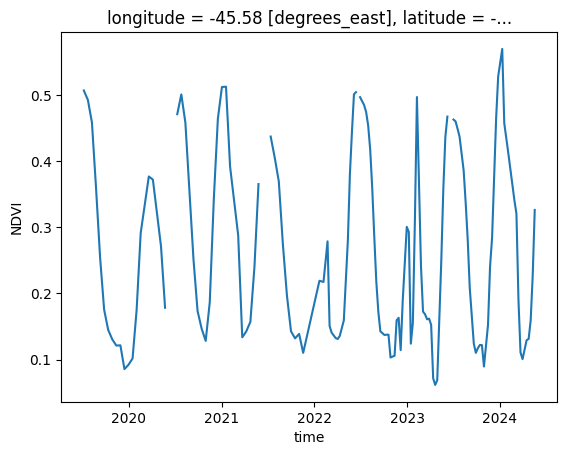

In [6]:
xy = -49.65683,-20.37023
xy = -45.5792,-11.6610
df['NDVI'].sel(longitude = xy[0], latitude = xy[1], method = 'nearest').plot()

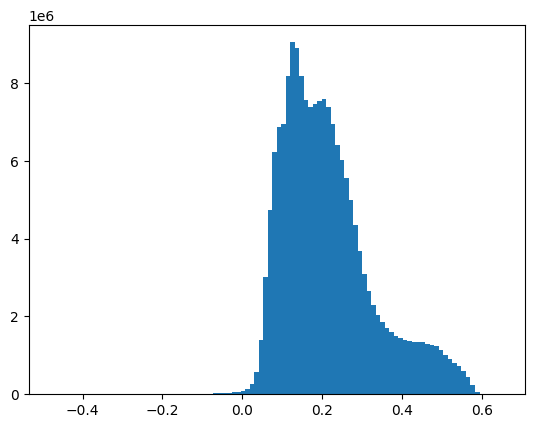

In [7]:
plt.hist(np.ravel(df['NDVI'].values), bins = 100);

In [ ]:
outf

In [ ]:
df['NDVI'].to_netcdf(outf+'ndvi_2013-2024.nc')

### AND THE STATS

In [ ]:
ndvi_anom, ndvi_z = zscore( df )

In [ ]:
ndvi_anom

In [ ]:
#ndvi_z['NDVI'].sel(longitude = xy[0], latitude = xy[1], method = 'nearest').plot();
plt.hist(np.ravel(ndvi_anom['NDVI'].values), bins = 100);

In [ ]:
yr = (2018,2024)
mr = (3,6)
season = 'gs36'
qs = [ .10 , .25 , .50 , .75 , .90 , .99 ]

In [ ]:
for ano in range( yr[0] , yr[1]):
    t0 = f'{ano}-{str(mr[0]).zfill(2)}'
    t1 = f'{ano}-{str(mr[1]).zfill(2)}'


    df2 = df.sel( time = slice( t0 , t1 ))
    if len(df2.time.values)>1:
        for q in qs:
            print(f'... quantile {q}')
            quantile = df2.quantile(q, dim = 'time') * 1000
            quantile = quantile.astype('int16')
            quantile.rio.to_raster(f'{outf}{vi}_{season}_{t0}_{t1}_{q}.tif')
            print(f'<< saved: {outf}{vi}_{season}_{t0}_{t1}_{q}.tif')
    else:
        print(f'nothing for {ano}')

### Quantiles
#### Select month and year range

In [ ]:
# payload
yr = (2013,2024)
mr = (3,6)
season = 'gs36'
qs = [ .10 , .25 , .50 , .75 , .90 , .99 ]

In [ ]:
# para inicio a meio do ano
for ano in range( yr[0] , yr[1]):
    t0 = f'{ano}-{str(mr[0]).zfill(2)}'
    t1 = f'{ano}-{str(mr[1]).zfill(2)}'
    print(t0,t1)

    df2 = df.sel( time = slice( t0 , t1 ))
    df2 = df2.chunk(dict(time=-1))
    if len(df2.time.values)>1:
        for q in qs:
            print(f'... quantile {q}')
            quantile = df2.quantile(q, dim = 'time') * 1000
            quantile = quantile.astype('int16')
            quantile.rio.to_raster(f'{outf}{vi}_{season}_{t0}_{t1}_{q}.tif')
            print(f'<< saved: {outf}{vi}_{season}_{t0}_{t1}_{q}.tif')
    else:
        print(f'nothing for {ano}')